<a href="https://colab.research.google.com/github/tizianofucci/A2NDLSegmentation/blob/main/Notebook/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [3]:
cwd = os.getcwd()

In [4]:
labels_dict  = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}


# Example: Image Segmentation
## Build segmentation

In [5]:
import shutil
import random
import json
import math

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.path.join(os.path.dirname(os.getcwd()),"VQA_Dataset")

#Save all possible path in order to be able to cycle over them
dataset_image_dir = os.path.join(cwd,'Images')

dataset_QA = os.path.join(cwd,'train_questions_annotations.json')

test_QA = os.path.join(cwd,'test_questions.json')


In [6]:
print(dataset_QA)
print(test_QA)

C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\train_questions_annotations.json
C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\test_questions.json


In [7]:
with open(dataset_QA) as f:
    q_dict = json.load(f)

In [8]:
for key in q_dict:
#     q_dict[key]['answer'] = labels_dict[q_dict[key]['answer']]
    print(q_dict[key]['answer'])

man
blanket
bench
yes
man
no
yes
brown
no
no
yes
no
no
1
gray
yes
yes
no
yes
no
soccer
yes
no
3
playing
sitting
food
no
2
man
yes
no
orange
no
1
yes
blanket
2
1
no
red
yellow
no
no
2
no
blue
red
2
2
baseball
yes
yes
nothing
dog
no
yes
no
no
yes
tree
2
stool
yes
no
yes
yes
no
1
yes
yes
2
yes
2
brown
yes
red
yes
yes
red
1
no
yes
1
0
no
red
no
3
2
no
yes
no
yes
woman
log
yes
no
tree
bike
yes
sitting
yellow
no
yes
2
3
no
no
floor
stool
yes
yes
2
yes
yes
yes
yes
red
no
no
no
no
1
no
yes
yes
yes
no
red
yes
yes
no
4
yes
yes
2
nothing
table
1
orange
no
no
standing
red
2
yes
4
no
yes
no
yellow
no
no
yes
no
2
brown
yes
2
blue
2
yes
sleeping
no
plant
apple
black
yes
no
no
yes
no
no
blue
yes
squirrel
3
4
soccer
no
orange
yes
yes
yes
no
grass
yes
left
yes
no
yes
bone
no
yellow
orange
no
no
red
girl
2
no
red
yes
2
white
log
yes
white
yellow
2
no
yes
yes
1
5
table
2
no
wine
yes
yes
blue
no
1
2
1
yes
4
table
red
1
yes
yes
2
no
nothing
no
couch
no
2
1
yes
yes
yes
yes
blue
3
5
5
0
brown
red
sandbox
yes


dog
plant
1
woman
yes
soccer
yes
no
boy
yes
2
yes
blue
bench
yes
book
book
yes
yes
yes
woman
no
playing
yes
yes
yes
yes
2
2
3
blue
yes
yes
yes
yes
monkey bars
no
baseball
yes
plant
yes
table
yes
yes
yes
green
yes
no
2
2
blue
bike
orange
wine
3
cat
yes
blue
yes
2
4
tree
yes
2
yes
table
yes
no
yes
yes
2
red
1
no
red
yes
white
yes
yes
no
yes
yes
yes
yes
woman
no
yes
red
no
1
yes
1
bench
yes
3
white
yes
red
2
3
4
standing
no
yes
yes
no
yes
yes
grass
2
0
yes
yes
yes
yes
2
yellow
red
1
1
yes
no
1
red
no
yes
yellow
white
woman
yes
yes
2
yes
no
yes
yes
no
food
yes
no
yes
red
yes
cat
red
yes
1
green
yes
green
no
gray
nothing
2
1
yes
yes
yes
yes
no
no
wine
dog
no
yes
no
1
left
brown
no
yes
3
yes
white
yes
girl
no
brown
2
no
no
1
yes
gray
no
no
2
2
dog
yes
football
blue
no
3
no
1
yes
2
gray
yes
nothing
5
2
sitting
no
1
no
3
yes
no
floor
yes
yes
yes
yes
tree
no
no
blanket
3
white
1
dog
2
no
no
yes
2
no
red
yes
sunny
no
yes
no
yes
red
no
yes
white
no
no
girl
no
no
0
2
1
sitting
3
yes
yes
yes
yes
2


yes
dog
white
yes
yes
yes
log
yes
pie
blue
right
no
yes
2
yes
table
brown
yes
yes
no
2
4
2
no
yes
no
monkey bars
yes
yes
brown
bone
playing
no
1
yes
dog
dog
yes
2
4
cat
no
1
yes
stool
3
no
white
brown
no
yes
no
no
brown
yes
3
yes
0
no
yes
wine
yellow
1
black
bird
brown
yes
soccer
no
no
yes
no
yes
4
man
yes
no
yes
1
tree
yes
yes
no
yes
tree
2
yes
brown
red
yes
yellow
red
green
white
no
yes
watermelon
yes
yellow
no
no
no
yes
dog
2
2
soccer
yes
yes
yes
yes
yes
rug
yes
no
yes
2
no
no
yes
no
1
no
brown
yes
no
2
yes
yes
2
yellow
no
red
no
no
baseball
5
soccer
yes
no
5
yes
yes
no
yes
no
football
yes
yes
yes
2
2
1
yes
no
3
1
no
yes
orange
yes
no
5
0
no
yellow
yes
2
yes
5
man
no
2
3
2
yes
white
2
sleeping
standing
blue
cat
no
no
orange
yes
no
no
no
yes
brown
no
yes
no
no
yes
playing
yes
2
yes
yes
1
yes
2
no
no
green
yes
4
yes
plant
yes
yes
no
boy
1
no
2
no
brown
no
2
yes
yes
no
no
no
dog
0
yes
yes
black
3
yellow
1
blue
couch
yes
no
yes
2
red
no
green
no
no
cat
no
food
2
yes
yes
bench
no
no
yes


yes
yes
yes
no
blue
yes
red
yes
no
yes
apple
yes
2
yes
yes
yes
yes
yes
monkey bars
red
no
no
yes
no
dog
yes
no
no
no
no
yes
2
4
2
sitting
2
yes
yes
yes
2
red
1
no
yes
no
yes
no
yes
yes
2
right
yes
yes
monkey bars
no
plant
yes
yes
no
yes
yes
no
no
no
0
yes
left
yes
no
no
yes
football
red
no
white
book
no
no
nothing
yes
yes
tree
yes
standing
2
no
no
bird
watermelon
no
no
1
no
yes
3
no
yes
2
no
red
no
dog
red
no
yes
no
5
no
no
2
no
blanket
yes
yes
no
yes
pie
yes
0
1
right
red
blue
no
yes
no
yes
no
yes
yes
orange
2
4
white
4
blanket
no
0
yes
watermelon
yes
no
2
brown
2
no
4
yes
couch
left
no
yes
yes
yes
yes
rug
no
no
no
woman
brown
red
2
plant
no
yes
yes
floor
yes
yes
yes
green
no
2
no
4
red
2
red
yes
no
no
squirrel
wine
white
no
white
no
yes
red
no
no
table
right
no
tree
squirrel
baseball
1
yes
4
gray
no
blue
yes
sunny
yes
2
yes
no
orange
bench
yes
no
tree
green
yes
no
no
no
girl
yes
no
no
yes
3
yes
yes
yes
blanket
blanket
3
yes
yes
no
right
no
yes
3
sandbox
1
no
orange
2
no
bird
red
yes


yes
brown
brown
red
yes
couch
yes
red
yes
yes
white
no
sandbox
4
yes
table
yes
2
book
red
yes
boy
grass
2
bone
no
watermelon
2
2
plant
dog
no
black
yes
yes
2
rug
yellow
red
yes
white
yes
yes
2
2
plant
no
bone
yes
no
no
5
book
plant
no
yes
yes
no
yes
table
football
yes
no
food
1
red
no
no
no
no
no
yes
yes
yes
no
yes
football
no
1
2
no
dog
book
no
no
2
yes
1
yes
sandbox
4
yes
0
3
bench
no
red
2
orange
yellow
1
cat
no
yes
yellow
no
yes
1
no
3
no
black
green
no
yes
no
brown
blue
yes
soccer
yes
2
3
yes
2
yes
no
yes
no
4
5
yes
black
yes
2
2
yes
no
no
sunny
no
blue
yes
monkey bars
sunny
5
1
no
yes
yellow
yes
yes
nothing
2
sitting
no
1
yes
no
red
yes
yes
yes
floor
yes
no
yes
brown
3
yes
no
yes
monkey bars
2
man
right
white
no
yes
no
yes
squirrel
gray
4
no
no
yes
yes
yes
log
yes
yes
yes
yes
no
yes
no
4
no
yes
green
no
no
no
yes
food
yes
1
sitting
yes
no
3
chair
no
yes
nothing
2
1
yes
bench
yes
yes
yes
yes
yes
plant
yellow
2
1
2
football
man
red
cat
yes
no
woman
tree
yes
2
tree
sleeping
2
no
no


yes
yellow
yes
football
football
yes
2
grass
yes
food
yes
standing
yes
no
3
no
1
2
no
yes
tree
no
5
2
no
no
playing
2
white
brown
book
yes
1
no
5
yes
bone
no
yes
yes
red
2
yes
yellow
girl
yes
1
right
black
yes
yes
couch
nothing
1
no
2
yes
yes
yes
green
yes
yes
yes
0
yes
wine
no
yes
yes
yes
3
yes
yes
yes
no
yes
1
yes
stool
yes
no
yes
tree
football
football
blue
no
2
white
gray
black
floor
no
no
yes
no
2
yes
no
yes
1
no
yes
no
2
yes
playing
football
yes
2
wine
woman
nothing
2
gray
no
2
0
brown
yes
yes
sitting
5
yes
dog
white
food
2
couch
yes
no
2
3
white
apple
no
blanket
chair
yes
yes
yes
no
no
2
yes
2
no
yes
yes
yes
yes
yes
1
1
no
yes
no
yes
yes
yes
2
soccer
yes
no
no
4
blue
3
3
2
yes
3
yes
2
woman
yes
stool
red
3
yes
white
sitting
yes
tree
yes
no
yes
yes
yes
yes
yes
white
yes
yes
plant
no
sitting
left
no
white
yes
no
1
1
no
2
yes
1
yes
cat
no
2
no
yes
4
yes
yes
yes
yes
yes
yes
yes
black
yes
2
yes
no
blue
yes
dog
2
bone
1
no
no
yes
no
orange
floor
yes
no
red
yellow
yes
brown
no
yes
yes


no
white
no
cat
yes
yes
left
2
orange
yes
no
1
yes
1
2
wine
yes
monkey bars
no
2
yes
playing
yes
yellow
yes
yes
no
yes
no
no
yes
yes
wine
football
apple
woman
0
no
no
yes
yes
squirrel
bike
no
4
brown
2
nothing
rug
5
blue
bone
no
no
no
yes
5
yes
yes
2
dog
standing
3
yes
no
white
no
yes
sandbox
1
yes
yes
no
yes
yes
3
yes
cat
book
yes
sleeping
no
yellow
yes
yellow
yes
2
no
yes
yes
yes
3
apple
yes
3
0
2
1
yes
2
yellow
man
soccer
yes
sitting
yes
no
yes
2
3
2
no
yes
no
yes
2
no
yes
yes
blue
yes
2
yes
nothing
blue
tree
grass
yes
2
yes
no
yes
2
yes
yes
3
yellow
yes
brown
1
yes
yes
no
dog
3
blue
1
yes
2
no
1
yes
yes
yes
dog
yes
floor
4
brown
no
bench
no
red
yes
no
yes
yes
yes
yes
red
football
yes
yes
1
yes
black
dog
1
1
yes
no
yes
yes
3
white
yes
girl
no
2
white
yes
yes
no
chair
no
4
2
yes
yes
bench
2
no
yes
yes
red
no
yes
no
yes
log
gray
yes
yes
red
yes
4
no
yes
yes
3
yes
3
yes
yes
red
red
yes
yes
yes
yes
blanket
yes
yes
yes
yellow
yes
1
2
yes
3
yes
no
no
right
2
2
yes
yes
no
3
no
yes
brown
no

yes
yes
yes
no
no
2
yes
2
3
yes
yes
4
3
yes
yes
yes
sunny
1
football
yes
yes
yes
yes
no
dog
2
no
no
yes
no
1
no
no
3
yes
no
monkey bars
no
yes
red
yes
right
yes
1
boy
no
red
2
white
no
yes
yes
tree
yes
2
no
1
yes
2
no
yes
yes
2
yes
yes
no
4
bench
green
no
yes
yes
red
2
tree
2
left
yes
1
yes
yes
yes
no
bike
nothing
blue
no
no
orange
yes
dog
sitting
green
yes
1
2
no
no
yes
no
watermelon
no
stool
no
no
red
yes
yes
no
blue
playing
2
no
no
chair
yes
brown
no
red
yes
yes
cat
no
yes
wine
no
1
yes
no
stool
left
sleeping
yes
yes
no
no
yes
yes
yes
no
no
yes
yes
no
white
1
2
no
4
left
yes
3
red
no
yes
no
1
yes
red
2
no
cat
yes
soccer
grass
blanket
yes
2
yes
yes
3
stool
yes
white
yes
apple
tree
wine
man
red
0
no
plant
yes
no
yes
yes
no
yes
rug
yes
yes
red
yes
1
couch
0
no
no
bird
white
yes
yes
yes
no
woman
yes
no
2
sleeping
4
no
cat
pie
no
1
football
yes
dog
2
yes
bike
yes
no
blue
4
no
yes
yes
red
yes
cat
1
red
table
table
yes
no
yes
yes
rug
rug
nothing
soccer
yes
2
white
no
grass
3
red
yes
yes
re

no
man
no
yes
standing
no
3
food
yes
no
yes
2
yes
right
soccer
yes
2
playing
2
cat
yes
no
no
yes
girl
2
2
yes
no
yes
yes
2
no
yes
no
no
no
yes
right
yes
yes
2
book
no
blue
no
2
2
no
red
apple
2
2
yes
couch
yellow
no
sitting
yes
chair
yes
yes
dog
monkey bars
yes
no
boy
yes
1
right
no
1
yes
yes
2
2
blue
no
no
bone
4
sandbox
gray
playing
no
yes
yes
yes
no
blanket
no
yes
4
yes
no
no
yes
yes
white
no
2
4
yes
no
plant
no
no
sandbox
no
3
no
5
2
yes
yes
couch
2
yes
yes
table
yes
yes
yes
yes
no
yes
yes
no
gray
sitting
yes
yes
white
no
no
1
yellow
cat
1
yes
soccer
no
table
white
yes
cat
plant
white
yes
floor
no
no
no
2
tree
1
playing
2
bench
no
food
3
sitting
yes
0
yes
couch
no
1
no
3
yes
no
2
2
no
1
yes
yes
no
soccer
yes
4
yes
no
yes
2
3
yes
standing
yes
apple
yes
no
sitting
blue
yes
no
no
3
2
dog
yes
no
no
yes
yes
nothing
yes
yes
chair
dog
no
1
no
red
2
red
yes
yes
yes
no
yes
yellow
squirrel
yes
2
yes
yes
yes
yes
soccer
black
no
0
yes
yes
yes
wine
no
no
no
no
yes
2
yes
sleeping
rug
2
yes
1
1
y

2
no
no
stool
yes
no
white
bench
squirrel
yes
no
no
brown
no
orange
yes
3
0
yes
no
tree
yes
yes
1
5
table
watermelon
no
yes
sitting
2
yes
bone
3
no
yes
yes
yes
yes
rug
2
yes
sitting
no
3
yes
no
no
no
yes
yes
no
2
soccer
bone
yes
yes
yes
white
yes
yes
sitting
no
pie
no
1
standing
no
yes
yes
wine
yes
white
orange
yes
yes
no
soccer
yes
2
stool
yes
yes
yes
floor
brown
yes
no
dog
yes
2
yes
brown
no
yes
yes
yes
no
no
yes
yes
yes
yes
orange
4
yes
0
red
yes
brown
chair
4
yes
bench
yes
no
yes
yes
brown
2
brown
boy
no
nothing
yes
monkey bars
yes
standing
1
no
yes
yes
no
3
yes
yes
no
yes
brown
soccer
sitting
book
yes
no
blue
no
2
5
no
rug
no
red
white
yes
soccer
wine
blue
no
yellow
table
white
table
1
floor
yes
gray
no
yes
no
4
yes
white
yes
girl
no
gray
no
no
plant
yes
yes
no
yes
yes
no
yes
yes
no
girl
no
yes
green
yes
yes
1
no
no
no
couch
no
yes
no
pie
3
4
yes
couch
yes
1
no
yes
log
yes
yes
1
blue
1
yes
yes
soccer
no
4
yes
no
no
yes
yes
no
yes
2
sleeping
no
no
5
0
yes
girl
3
white
yes
yes
yes
w

book
no
yes
dog
yes
yes
yes
yes
yes
yes
yes
red
2
grass
no
yes
girl
yes
white
no
yes
no
yes
couch
squirrel
dog
no
yes
white
white
yes
3
2
5
2
2
brown
yes
brown
dog
sitting
no
yes
right
no
brown
gray
2
grass
no
no
baseball
yellow
no
sitting
no
2
no
no
bike
5
bench
3
no
yes
1
yes
left
no
no
couch
yes
yes
sunny
yes
no
no
red
no
red
squirrel
yes
red
blue
football
yes
no
yes
yes
yes
yes
1
girl
red
yes
no
0
no
white
2
nothing
1
no
2
yes
yes
green
cat
2
yes
no
soccer
2
no
yes
yes
plant
playing
no
no
no
red
yes
1
woman
yes
red
yes
couch
no
no
pie
no
yes
no
yes
yes
right
yes
blue
yes
yes
no
yes
yes
3
yes
2
white
baseball
yes
left
orange
yes
3
2
yes
yes
left
bone
yes
squirrel
1
apple
2
bird
yes
0
yes
soccer
soccer
watermelon
gray
no
soccer
1
2
man
apple
2
no
no
yes
no
yellow
no
no
soccer
no
no
right
left
yes
no
girl
floor
yes
yes
yes
yes
no
no
no
yes
1
yes
yes
2
yes
yes
red
2
yes
yes
tree
no
no
yes
2
no
apple
white
1
yes
yellow
sleeping
yes
sleeping
yes
yes
no
yes
no
playing
yellow
4
yes
yes
ben

right
3
no
yes
no
yes
yes
no
0
no
no
red
apple
no
yes
yes
blue
yes
yes
white
floor
yes
no
no
yes
yes
yes
no
no
orange
yes
football
table
1
orange
red
2
yes
no
yes
yes
no
no
2
sitting
no
no
food
yes
yes
yes
no
no
no
yes
no
blue
no
no
table
yes
brown
red
2
yes
man
yes
no
no
yes
wine
no
2
yes
2
bike
1
yes
yes
floor
couch
no
apple
yes
sandbox
sandbox
no
pie
yes
2
yes
brown
yellow
floor
red
no
0
soccer
yes
dog
yes
yes
playing
yes
yes
yellow
watermelon
yes
2
yes
yes
no
yes
yes
yes
woman
2
red
no
white
table
no
no
no
yes
rug
book
woman
no
yes
no
sandbox
white
no
table
2
yes
2
yes
4
0
cat
no
red
no
2
yes
2
green
squirrel
yes
no
yes
no
yes
1
orange
no
couch
yes
yes
yes
sandbox
blue
sunny
no
2
yes
2
man
no
yes
2
4
red
no
3
yes
yellow
yes
no
nothing
yes
food
no
red
white
yes
dog
no
no
no
yes
1
2
no
blue
yes
yes
red
yes
yes
1
2
3
red
no
monkey bars
log
yes
2
2
playing
2
2
yes
blue
2
left
yes
yes
no
5
yes
yes
no
no
yes
couch
yes
no
no
yes
yes
yes
brown
1
yes
yes
2
yes
white
yes
yes
yes
red
yes
no
y

2
yes
no
yes
yes
yes
4
yes
red
no
yes
no
no
yes
yes
red
no
no
dog
no
yes
wine
yes
yes
no
bone
2
brown
no
yes
yes
food
yes
yes
sleeping
yes
no
red
bone
yes
no
no
bird
no
yellow
yes
yes
yes
no
nothing
yes
yes
no
yes
2
yes
yes
yes
no
4
couch
red
rug
red
no
wine
no
yes
gray
yes
2
no
yes
blanket
sleeping
no
no
food
no
1
wine
yes
no
yes
1
no
no
yes
no
5
yes
blanket
no
yes
bench
blue
yes
red
right
green
yes
no
yes
yes
yes
no
yellow
yes
yes
1
no
2
yes
no
brown
floor
standing
blue
white
1
red
2
nothing
4
woman
soccer
no
yes
yes
red
yes
playing
no
yes
yes
yes
blue
2
girl
brown
couch
no
no
2
yes
yes
5
no
log
no
yes
rug
yes
no
red
no
yes
yes
yes
1
soccer
cat
stool
yes
no
yes
yes
yes
yes
nothing
black
yes
1
cat
yes
yes
no
no
man
yes
watermelon
cat
no
red
yes
woman
yes
woman
red
no
yes
yes
no
yes
yes
1
right
no
yes
no
grass
5
yellow
no
no
nothing
tree
no
1
food
baseball
yes
yes
4
yellow
baseball
no
2
yes
no
1
no
table
red
no
standing
yes
yes
yes
watermelon
no
no
sleeping
yes
no
no
yes
yes
yes
1
2
1


bird
yes
yes
table
2
3
cat
2
yes
no
yes
no
yes
football
football
yes
baseball
yes
no
plant
yes
yes
yes
apple
yes
yes
brown
yes
red
yes
bike
no
bench
watermelon
yes
yes
yes
no
yes
log
white
yes
yes
yes
green
0
no
1
no
yes
2
yellow
no
2
yes
yes
2
white
yes
dog
yes
yes
no
0
1
squirrel
yes
sandbox
1
no
man
yes
girl
5
no
4
yes
2
couch
yes
yes
no
yes
yes
yes
no
no
no
yes
yes
no
dog
1
no
no
no
yes
2
yes
3
floor
2
yes
tree
no
yes
stool
no
bench
yes
no
plant
red
2
yellow
red
table
1
1
yes
yes
no
right
5
1
yellow
girl
2
yes
watermelon
yes
plant
yes
no
yes
yes
no
yes
bird
yes
3
yes
yes
yes
yes
red
yes
no
yes
nothing
yes
no
yes
yes
black
no
yes
2
food
no
1
1
log
sunny
no
1
yes
1
white
1
yes
no
4
yes
green
1
no
white
0
no
no
1
yes
2
red
no
3
5
no
orange
no
3
gray
yes
yes
no
yes
1
no
no
yes
yes
3
no
wine
yes
dog
yes
yes
3
yes
dog
2
yes
no
2
dog
bone
no
no
2
yes
baseball
yellow
2
brown
2
no
gray
1
boy
yes
gray
white
black
yes
sunny
blue
no
yes
1
3
couch
yes
yes
rug
yes
no
floor
yes
2
couch
yes
no
no


white
woman
yes
sitting
no
yes
orange
3
0
no
no
apple
yes
gray
yes
2
yes
sitting
1
red
white
4
yes
sleeping
no
bench
3
1
woman
4
white
no
yes
sitting
2
2
yes
yes
no
1
red
white
2
yes
no
no
red
orange
white
yes
plant
no
gray
yes
yes
no
no
yes
2
no
red
yes
yes
2
yes
yes
table
yes
no
no
4
yes
yes
no
yes
yes
no
2
yes
white
no
yes
0
no
football
yes
yes
no
no
no
yes
1
2
1
red
2
yes
1
yes
yes
2
no
yes
2
yes
no
no
yes
no
no
3
no
1
yes
book
yes
yes
no
no
2
0
yes
no
no
yes
blue
yes
3
0
yes
2
yes
yes
dog
no
baseball
yes
no
yes
no
no
red
no
3
no
nothing
yes
yes
yes
yes
yes
man
right
no
yes
blue
no
3
1
yes
yes
no
yellow
1
no
yes
yes
yes
white
log
3
bone
yes
no
no
yes
floor
white
nothing
yes
no
no
no
no
red
yes
yes
plant
no
yes
no
yes
yes
1
yes
yes
nothing
0
no
no
no
yes
1
3
yes
red
yes
yes
yes
no
red
yes
no
2
yes
yes
yes
floor
yes
no
white
no
no
no
2
yellow
red
no
yes
yes
no
yes
no
yes
4
yes
table
dog
no
sleeping
no
no
yes
yes
blanket
playing
yes
monkey bars
yes
yes
yes
5
sandbox
football
yes
2
yes

no
nothing
no
log
yes
3
yes
yes
no
no
3
no
couch
table
no
1
yes
1
2
no
book
4
yes
dog
yes
3
dog
yes
yes
no
5
girl
wine
white
wine
yes
gray
yes
baseball
no
baseball
yellow
2
2
no
black
red
2
yes
no
rug
rug
yes
yes
yes
no
yes
yes
football
yes
black
white
no
yes
2
2
baseball
yellow
1
yes
man
white
soccer
yes
green
sandbox
1
no
yes
no
yes
left
yes
yes
2
yes
2
no
table
no
no
3
black
no
table
yes
yes
yes
yes
left
no
left
yes
no
no
no
yes
yes
no
yes
yes
yes
yes
no
red
no
2
bone
4
dog
apple
yes
2
no
red
yes
2
white
2
no
yes
blue
no
gray
1
left
cat
sitting
yes
yes
yes
no
1
yes
red
yes
playing
yes
yes
no
yes
yes
yes
no
yes
0
green
2
no
2
1
red
girl
book
couch
no
1
baseball
yes
watermelon
soccer
no
bone
2
yes
standing
no
wine
2
no
yes
0
baseball
yes
1
yellow
no
yes
brown
no
2
cat
man
no
yes
black
yes
no
2
blue
rug
man
yes
yes
3
no
squirrel
no
1
blue
no
no
yes
yes
red
yes
grass
2
no
yes
bike
yes
2
red
no
dog
yes
green
yes
yes
yes
yes
2
yes
yes
1
yes
yes
no
yes
4
yes
yes
no
no
2
yes
red
white
stand

couch
4
red
3
yes
rug
white
grass
no
blue
cat
no
no
yes
1
boy
1
no
no
boy
no
yes
no
no
no
no
no
no
yellow
yes
no
blue
bench
no
yes
yes
floor
no
yes
3
3
bird
bird
yes
no
book
yes
2
yes
no
red
yes
no
2
yes
table
3
yes
yes
5
black
no
nothing
yes
couch
2
black
no
no
no
2
bike
blanket
2
yes
no
no
yes
yes
2
yes
2
no
log
no
yes
yes
yes
2
man
red
log
playing
sandbox
no
book
no
yes
yes
yes
sandbox
yes
no
yes
no
yes
no
no
cat
floor
blue
2
no
2
yes
no
yes
2
dog
monkey bars
yes
sunny
no
food
white
yes
yellow
2
4
1
yes
1
3
yes
yes
yes
yes
2
dog
yes
no
yes
yes
no
red
1
yes
blue
yes
1
apple
sunny
no
white
orange
yes
couch
no
yes
yes
red
yes
3
yes
no
3
5
baseball
squirrel
no
yes
sandbox
sleeping
3
no
rug
yes
yes
yes
yes
no
4
black
brown
yes
2
no
red
yellow
no
blue
boy
yes
chair
bench
2
red
1
no
yes
yes
2
red
no
no
yes
white
white
brown
no
yes
monkey bars
no
yes
2
no
yes
yes
yes
grass
1
sandbox
5
yes
yes
yes
sandbox
yes
monkey bars
yes
no
no
yes
1
yes
bench
yes
red
2
3
no
no
soccer
cat
no
no
no
2
2
yes

yes
4
brown
yes
soccer
playing
red
orange
yes
blue
chair
wine
no
1
1
yes
no
4
red
yes
yes
no
no
2
yes
sunny
sandbox
chair
yellow
no
no
3
yes
yes
yes
brown
no
yes
yes
no
no
yes
yes
blue
girl
dog
yes
yes
red
yes
4
yes
brown
yes
cat
watermelon
yes
yes
yes
no
no
yes
woman
3
2
yes
no
yes
yes
no
yes
plant
bench
yes
woman
2
no
no
yes
no
blue
no
bench
yes
yes
red
couch
no
yes
yes
5
no
baseball
no
white
white
brown
no
yes
yes
yes
red
yes
tree
no
black
white
brown
black
football
2
1
couch
no
yellow
no
tree
food
no
yes
yes
0
blue
yes
black
no
blanket
yes
yes
yes
no
plant
sleeping
yes
no
left
no
floor
yes
3
yes
table
yes
plant
yes
plant
yes
yes
yes
table
yes
no
yes
yes
no
no
0
brown
sleeping
no
yes
3
dog
no
wine
2
brown
yes
yes
no
no
no
5
red
yellow
3
yes
yes
yes
grass
yes
no
no
1
no
no
2
1
girl
orange
right
pie
yes
no
yellow
black
white
yes
red
yes
yes
yes
no
no
yes
no
1
monkey bars
log
no
yes
3
yes
yes
plant
no
red
yes
no
gray
no
no
yes
boy
yes
squirrel
no
yes
yes
yes
2
2
no
no
1
2
2
no
no
blue


0
no
no
3
no
yes
white
no
yes
no
3
no
blue
yes
apple
soccer
yes
no
yes
yes
no
white
yes
no
yes
yes
no
bone
bird
no
2
no
1
nothing
no
yellow
yes
bird
football
3
left
blue
3
2
no
no
black
yes
wine
0
yes
white
1
yes
right
yes
2
yes
no
3
stool
2
no
red
dog
red
yes
yes
right
yes
wine
no
no
yes
1
no
2
yes
yes
2
gray
yes
food
no
yes
no
yes
2
yes
no
yes
yes
monkey bars
yes
yes
1
yes
4
no
bike
0
yes
yes
no
4
no
left
no
no
no
no
2
no
no
no
floor
brown
no
no
no
apple
yes
wine
yes
1
red
no
yes
no
2
no
no
3
no
left
no
no
left
yes
yes
squirrel
no
yes
no
no
no
yes
1
baseball
3
no
yellow
tree
yes
1
no
2
1
0
cat
plant
red
sunny
sandbox
2
playing
yes
no
yes
wine
yes
no
yes
yes
1
yes
2
no
yes
no
4
no
yes
yes
table
yes
yes
dog
yes
yes
monkey bars
yes
yes
sandbox
cat
black
man
1
no
yes
right
left
soccer
dog
3
yes
yes
2
no
2
dog
no
yes
yes
2
no
yes
left
red
no
cat
no
yes
bike
yes
no
no
0
yes
white
yes
yes
no
yes
no
1
2
yes
3
yes
no
no
apple
yes
white
yes
yes
2
apple
1
yes
plant
white
no
no
no
yes
2
green
no

2
yellow
yes
yes
yes
yes
playing
no
grass
yes
2
yes
yes
2
no
2
yes
yes
floor
yes
no
football
yes
1
tree
4
2
red
brown
bone
1
sitting
2
yes
red
yes
yes
bird
no
yes
rug
1
man
yes
yes
2
no
yes
soccer
5
yes
no
yes
man
yellow
yes
yes
1
0
yes
dog
yes
5
yes
no
2
no
no
yes
yes
no
yes
2
blue
floor
yes
yes
no
yes
no
yes
yes
no
rug
2
yes
no
1
baseball
yes
no
woman
yes
yes
brown
yes
wine
yes
yes
yes
no
yes
yes
no
no
yes
book
no
yes
no
yes
red
no
2
no
yes
yes
dog
no
soccer
no
yes
yes
red
white
yes
4
no
0
1
red
sleeping
2
soccer
green
dog
no
stool
no
yes
no
0
yes
yes
sitting
4
no
yes
no
cat
1
yellow
no
sandbox
yes
4
2
4
no
yes
no
dog
yes
food
1
yes
baseball
no
brown
yes
cat
cat
2
playing
yes
yes
yes
yes
2
no
tree
3
yes
1
table
right
yes
yes
yes
yes
yes
yes
log
3
yes
woman
2
yes
gray
brown
3
no
yes
yes
yes
dog
yes
no
no
yes
yes
yes
no
watermelon
yes
2
yes
apple
no
yes
no
dog
yes
yes
bench
yes
right
cat
no
orange
2
no
red
yes
man
red
no
yes
1
yes
no
yes
no
red
dog
yes
watermelon
green
yes
3
no
rug
rig

man
2
1
no
yes
2
yes
no
no
yes
baseball
red
sleeping
no
yes
2
yes
no
log
no
playing
no
no
baseball
no
yes
no
blue
gray
rug
no
yes
yes
yes
0
nothing
yes
gray
yes
no
no
no
yes
red
soccer
yellow
yes
no
yes
3
black
2
book
no
no
no
plant
no
brown
stool
no
2
yes
yes
blue
no
no
no
yes
yes
yes
1
no
2
yes
yes
blue
4
log
black
4
book
3
2
2
squirrel
2
yes
soccer
1
dog
yes
no
no
no
yes
yes
3
4
sitting
yes
right
red
no
2
no
4
5
2
food
red
yes
white
yes
yes
red
4
2
yes
yes
5
yes
2
yes
yes
red
wine
yes
2
no
2
3
0
no
no
0
no
yes
yes
football
1
orange
red
stool
1
yes
3
yes
yes
rug
yes
1
no
yes
yes
bird
soccer
playing
2
2
3
yes
3
plant
yes
yes
yes
yes
no
no
no
bone
2
plant
white
yes
no
grass
2
red
white
2
4
boy
2
no
no
soccer
no
black
2
white
floor
yes
yes
yes
sitting
2
no
green
squirrel
yes
wine
0
no
yes
chair
wine
sleeping
food
tree
yellow
yes
3
3
yes
no
no
yes
yes
no
yes
no
yes
red
yellow
no
yes
white
no
2
no
no
no
no
no
log
1
yes
no
white
no
yes
sleeping
no
no
yes
girl
yes
white
2
no
3
3
yes
3
yes
y

5
2
5
rug
no
no
1
2
yes
couch
no
no
no
no
yes
yes
no
yes
bone
no
table
3
playing
blanket
no
no
2
no
brown
yes
no
yes
1
football
red
yes
red
5
yes
yes
playing
yes
3
no
playing
yes
log
yes
2
no
3
playing
yes
no
cat
no
no
black
yes
5
yes
no
rug
no
2
green
yes
no
yellow
red
yes
yes
yes
yes
yes
2
no
3
1
no
no
no
no
yes
boy
yes
yes
3
no
yes
no
2
white
yellow
yes
no
yes
yes
floor
yes
yes
1
blue
no
yes
yes
yes
red
couch
3
yes
no
3
yes
right
yellow
2
yes
tree
left
white
stool
yes
cat
yes
yes
cat
yes
3
no
yes
yes
no
dog
no
yes
2
yes
3
white
0
no
yes
yes
pie
no
no
red
1
no
red
yes
yes
2
yellow
yes
apple
green
food
yes
apple
no
yes
0
white
no
yes
yes
yellow
yes
yes
floor
yes
no
yes
yes
no
2
1
no
table
yes
yes
yes
nothing
yes
no
1
3
yes
2
yes
no
yes
blue
yes
right
3
black
black
no
yes
2
right
1
no
no
plant
yes
woman
rug
0
yes
yes
yes
food
white
2
baseball
2
yes
red
yes
yes
yes
yes
bird
brown
yes
red
2
no
yes
dog
yes
no
2
log
no
yellow
no
yes
yes
woman
blue
red
4
yes
no
red
left
bone
yes
dog
no
yes


2
yes
no
brown
red
2
2
yes
yes
red
yes
3
yes
yes
no
yes
yes
yes
no
yes
yes
3
no
plant
yes
yes
no
2
no
no
bike
no
yes
1
no
left
2
no
no
yes
yes
2
2
bone
red
wine
3
no
2
chair
3
blue
1
blue
blue
yes
no
2
white
1
green
yes
green
1
red
red
yes
no
table
2
left
no
no
dog
tree
2
yes
yes
no
4
yes
yes
yes
1
no
yes
yes
right
yes
yes
1
yes
no
no
yes
no
yes
stool
3
no
no
no
no
no
no
sleeping
2
no
book
bike
2
no
4
4
white
yes
woman
tree
red
yes
no
dog
1
yes
yes
yes
2
playing
3
yes
2
yes
no
gray
table
girl
no
sitting
yes
no
brown
yes
no
yes
yes
yes
yes
4
no
log
grass
yes
2
cat
yes
yes
yes
food
4
yes
5
wine
yes
dog
nothing
yes
no
football
yes
football
no
yes
no
no
yes
yes
no
4
yes
squirrel
no
no
no
1
yes
no
0
4
grass
no
orange
yellow
no
brown
yes
white
bench
no
no
yes
yes
yes
green
yes
white
no
yes
standing
red
yes
food
yes
grass
tree
no
4
yes
boy
yes
no
2
no
no
no
no
sleeping
yes
no
brown
yes
2
white
no
4
blue
girl
2
yes
red
apple
yes
yes
3
yes
3
yes
yes
no
no
couch
red
yes
yes
3
food
yes
yes
no
1
y

no
no
yes
3
yes
1
1
red
yes
yes
2
yes
pie
sleeping
no
squirrel
no
yes
yes
no
no
table
yes
yes
3
no
yes
yes
yes
yes
yes
left
yes
no
bird
no
yes
brown
no
yes
green
girl
floor
cat
2
left
no
yes
yes
yes
no
2
rug
yes
no
yes
playing
yes
2
yellow
dog
yes
yes
3
yes
soccer
no
2
yes
yes
yes
green
orange
yes
no
no
yes
yes
yes
dog
blue
bike
2
1
yes
yes
baseball
yes
1
no
yes
brown
yes
no
grass
yes
no
2
yes
2
yes
yes
man
brown
no
yes
3
sleeping
4
no
yes
2
wine
yes
no
yes
yes
white
gray
green
2
no
yes
yes
yes
0
2
1
1
bench
2
yes
no
5
4
no
yes
white
5
standing
soccer
yes
3
no
1
cat
yes
monkey bars
yes
log
watermelon
squirrel
0
yes
1
yes
yes
no
no
yes
yes
yes
yes
yes
1
yes
gray
yes
yes
1
yes
blue
yes
bench
no
left
bird
2
no
yes
yes
playing
yes
no
yes
blue
no
football
yes
no
yes
sunny
baseball
3
4
1
yes
table
yes
yes
yes
bike
yes
yes
yes
bone
yes
yes
yes
0
red
yes
no
squirrel
yes
no
yes
no
5
no
yes
dog
red
red
plant
wine
no
floor
no
no
yes
2
yes
no
0
gray
yes
1
yellow
no
no
2
no
1
4
no
no
bird
no
no
no


boy
no
1
no
1
yes
no
yes
no
yes
yellow
yes
dog
1
right
no
2
yes
no
yes
sitting
2
yes
no
2
no
yes
red
yes
2
yes
no
plant
2
yes
yes
2
1
yes
no
yes
yes
1
no
blue
yes
yes
1
no
yes
yes
no
no
yes
4
no
5
yellow
blanket
yes
woman
baseball
no
no
yes
yes
yes
5
3
grass
yes
no
yes
floor
0
no
brown
table
2
yes
yes
yes
2
yes
no
left
yes
yes
table
yes
yes
no
2
no
sleeping
yes
man
3
red
yes
yes
no
tree
brown
floor
stool
no
2
blue
yes
yes
yes
1
yes
boy
1
yellow
yes
stool
plant
2
yes
yes
cat
no
gray
couch
no
yes
0
1
2
right
yes
yes
yes
yes
cat
2
no
no
red
white
bench
no
no
yes
yes
floor
no
2
yes
yes
2
no
yes
3
apple
2
no
no
football
no
baseball
yes
left
red
red
yes
no
yes
yes
2
yes
4
yes
yes
yes
no
book
yes
yes
table
food
yes
no
yellow
rug
1
yes
no
no
5
yes
yes
3
1
no
brown
yes
playing
yes
3
no
no
2
yes
1
3
no
playing
yes
3
no
3
girl
yes
yes
2
yes
blue
yes
yes
no
2
no
couch
floor
yes
2
yes
yes
yes
yes
no
red
2
bone
no
red
yes
yes
1
yes
yes
dog
yes
no
yes
no
yes
sleeping
left
no
yes
yes
2
sleeping
rug
ye

no
yes
2
no
yes
yes
bike
no
5
yes
food
yellow
green
no
yes
yes
yes
no
2
red
yes
no
no
yes
green
yes
yes
wine
4
no
4
4
2
yes
4
yes
black
red
2
table
yes
no
yes
yes
yes
sleeping
yellow
no
no
yes
no
no
2
white
1
yes
rug
yes
yes
no
no
table
food
yes
yes
no
1
rug
yes
no
no
yes
red
no
playing
no
yes
yes
1
couch
red
white
2
brown
blue
dog
grass
no
playing
yes
yes
2
yes
no
no
no
no
chair
yes
no
pie
yes
yes
chair
no
yes
red
yes
0
green
dog
sunny
watermelon
no
tree
3
yes
1
yes
no
no
football
yellow
black
standing
no
tree
yes
yellow
yes
yes
yes
football
no
2
no
yes
no
stool
yes
no
0
yes
yes
yes
yellow
no
yes
yes
3
yes
yes
yes
yes
yes
no
green
white
no
yes
yes
yes
woman
no
yes
woman
yes
1
yes
no
gray
no
no
yes
sleeping
yellow
right
baseball
yes
yes
red
left
red
2
red
yes
no
yes
boy
monkey bars
yes
3
yes
playing
yellow
yes
yes
3
soccer
yes
yes
no
bone
yes
2
yes
yes
red
yellow
yes
yes
yes
standing
yes
yes
yes
yellow
no
left
yes
table
yes
4
no
yes
blanket
5
no
no
no
no
no
yes
dog
yes
1
no
yes
left
ye

In [9]:
# Prepare dataset
# ---------------




MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

answers = []
questions = []
eng_sentences_train = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in q_dict:


#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    answer = q_dict[key]['answer']
    question = q_dict[key]['question']

    
    if (len(answer.split(' ')) > MAX_LEN or
          len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    questions.append(question)
    
    answer_arr = np.zeros(58)
    answer_arr[labels_dict[q_dict[key]['answer']]] = 1
    
    q_dict[key]['answer'] = answer_arr
    answers.append(answer)
    
    count += 1

print('Number of questions:', len(questions))

Number of questions: 58832


In [10]:
max(len(sentence.split(' ')) for sentence in questions)

23

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
ita_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
ita_tokenizer.fit_on_texts(questions)
ita_tokenized = ita_tokenizer.texts_to_sequences(questions)

ita_wtoi = ita_tokenizer.word_index
print('Total Questions words:', len(ita_wtoi))

max_ita_length = max(len(sentence) for sentence in ita_tokenized)
print('Max question length:', max_ita_length)

Total Questions words: 4641
Max question length: 22


In [12]:
# Pad to max italian sentence length
ita_encoder_inputs = pad_sequences(ita_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", ita_encoder_inputs.shape)


Italian encoder inputs shape: (58832, 22)


In [13]:
count = 0
for key in q_dict:
    q_dict[key]['question'] = ita_encoder_inputs[count]
    count+=1
 

In [14]:
# Build Encoder-Decoder Model
# ---------------------------

EMBEDDING_SIZE = 32

# ENCODER
# -------

encoder_input = tf.keras.Input(shape=[max_ita_length])
encoder_embedding_layer = tf.keras.layers.Embedding(len(ita_wtoi)+1, EMBEDDING_SIZE, input_length=max_ita_length, mask_zero=True)
encoder_embedding_out = encoder_embedding_layer(encoder_input)
encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=768))

encoder_output = encoder(encoder_embedding_out)
#encoder_states = [h, c]



# MODEL
model_lstm = tf.keras.Model(encoder_input,encoder_output)

In [15]:
model_lstm.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 32)            148544    
_________________________________________________________________
bidirectional (Bidirectional (None, 1536)              4921344   
Total params: 5,069,888
Trainable params: 5,069,888
Non-trainable params: 0
_________________________________________________________________


In [16]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
else :
    img_data_gen = ImageDataGenerator()


In [17]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    """
        CustomDataset inheriting from tf.keras.utils.Sequence.

        3 main methods:
          - __init__: save dataset params like directory, filenames..
          - __len__: return the total number of samples in the dataset
          - __getitem__: return a sample from the dataset

        Note: 
          - the custom dataset return a single sample from the dataset. Then, we use 
            a tf.data.Dataset object to group samples into batches.
          - in this case we have a different structure of the dataset in memory. 
            We have all the images in the same folder and the training and validation splits
            are defined in text files.

      """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
        elif which_subset == 'validation':
            subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
        with open(subset_file, 'r') as f:
            lines = f.readlines()
    
        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip()) 

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        
        
        
        
        # Read Image
        curr_filename = self.subset_filenames[index]
        element = q_dict[curr_filename]
        image = element['image_id']
        img = Image.open(os.path.join(self.dataset_dir, 'Images', image + '.png'))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        img = img.convert('RGB')
        
        # Resize image and mask
        img = img.resize(self.out_shape)
        

        
       # mask = mask.resize(self.out_shape)
    
        img_arr = np.array(img)
        
        
        
        question = element['question']
        answer = element['answer']
        #print(mask_arr.shape)
  
#         if self.which_subset == 'training':
#             if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                
#                 img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
#                 mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
#                 img_arr = self.img_generator.apply_transform(img_arr, img_t)
                
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
#                 out_mask = np.zeros_like(mask_arr)
#                 for c in np.unique(mask_arr):
#                     if c > 0:
#                         curr_class_arr = np.float32(mask_arr == c)
#                         curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
#                         # from [0, 1] to {0, 1}
#                         curr_class_arr = np.uint8(curr_class_arr)
#                         # recover original class
#                         curr_class_arr = curr_class_arr * c 
#                         out_mask += curr_class_arr
#         else:
    
        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
        
        pair = {"vgg16_input": img_arr, "zzz_input": question}
        
        return pair, answer

In [18]:
if not os.path.exists(os.path.join(cwd,"Splits/")):
    os.makedirs(os.path.join(cwd,"Splits/"))



import json



# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}

val=[]
train=[]

for key in q_dict:
# image_filenames = next(os.walk(os.path.join(dataset_dir[j],"Images/")))[2]



# for image_name in image_filenames:
    if 100*random.random() < 10:
        val.append(key)
    else:
        train.append(key)

with open(os.path.join(cwd,"Splits","train.txt"), 'w') as file:  # Use file to refer to the file object
    for i in train:
        a = file.write(str(i)+"\n")

with open(os.path.join(cwd,"Splits","val.txt"), 'w') as file:  # Use file to refer to the file object
    for i in val:
        a = file.write(str(i)+"\n")



In [19]:
#Creation of dataset generators (the commented line are the ones for getting also the haricot Dataset)

from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input 

img_h = 400
img_w = 700

dataset = CustomDataset(cwd, 'training', 
                        img_generator=img_data_gen, preprocessing_function=preprocess_input, out_shape=[img_w,img_h])

dataset_valid = CustomDataset(cwd, 'validation',
                              preprocessing_function=preprocess_input,out_shape=[img_w,img_h])



In [20]:
#Creation of datasets (the commented line are the ones for getting also the haricot Dataset)


train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=({"vgg16_input": tf.float32, "zzz_input": tf.float32}, tf.float32),
                                               output_shapes=({"vgg16_input": [img_h, img_w, 3], "zzz_input":  22}, 58)
                                              )

bs=10


train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=({"vgg16_input": tf.float32, "zzz_input": tf.float32}, tf.float32),
                                               output_shapes=({"vgg16_input": [img_h, img_w, 3], "zzz_input":  22}, 58)
                                              )

valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [21]:
# Let's test data generator
# -------------------------

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0 0 0 ... 15 486 1]
[0 0 0 ... 0 0 1]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

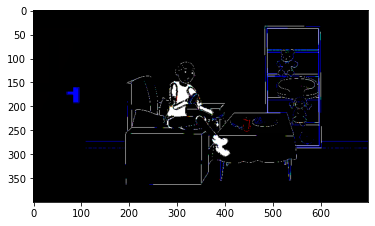

In [22]:

augmented_img = next(iterator)


image = augmented_img[0]['vgg16_input'][0]   # First element

tf.print (augmented_img[0]['zzz_input'][0])
tf.print (augmented_img[1][0])

plt.imshow(np.uint8(image))
plt.plot

In [23]:
#Loading of VGG that will be used as a Backbone
vgg = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# for layer in vgg.layers:
#   layer.trainable = False
freeze_until = 700 # layer from which we want to fine-tune

for layer in vgg.layers[:freeze_until]:
    layer.trainable = False
vgg.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 199, 349, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 349, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 199, 349, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [24]:
# This function is used for creating a model without skip connections
def create_model():

    model = tf.keras.Sequential()
    model2 = tf.keras.Sequential()
    # Encoder
    # -------
    model.add(vgg)
    model2.add(model_lstm)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    
    scores = tf.keras.layers.Multiply()([model.output, model2.output])
    
    denso = tf.keras.layers.Dense(units=256, activation='selu')(scores)

    drop = tf.keras.layers.Dropout(0.3)(denso)
    
    output = tf.keras.layers.Dense(units=58, activation='softmax')(drop)
    
    final_model = tf.keras.Model([model.inputs,model2.inputs], output)


    return final_model

In [25]:
model = create_model()

In [26]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inception_resnet_v2_input (Inpu [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v2 (Functional (None, 11, 20, 1536) 54336736    inception_resnet_v2_input[0][0]  
__________________________________________________________________________________________________
functional_1_input (InputLayer) [(None, 22)]         0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1536)         0           inception_resnet_v2[0][0]        
_______________________________________________________________________________________

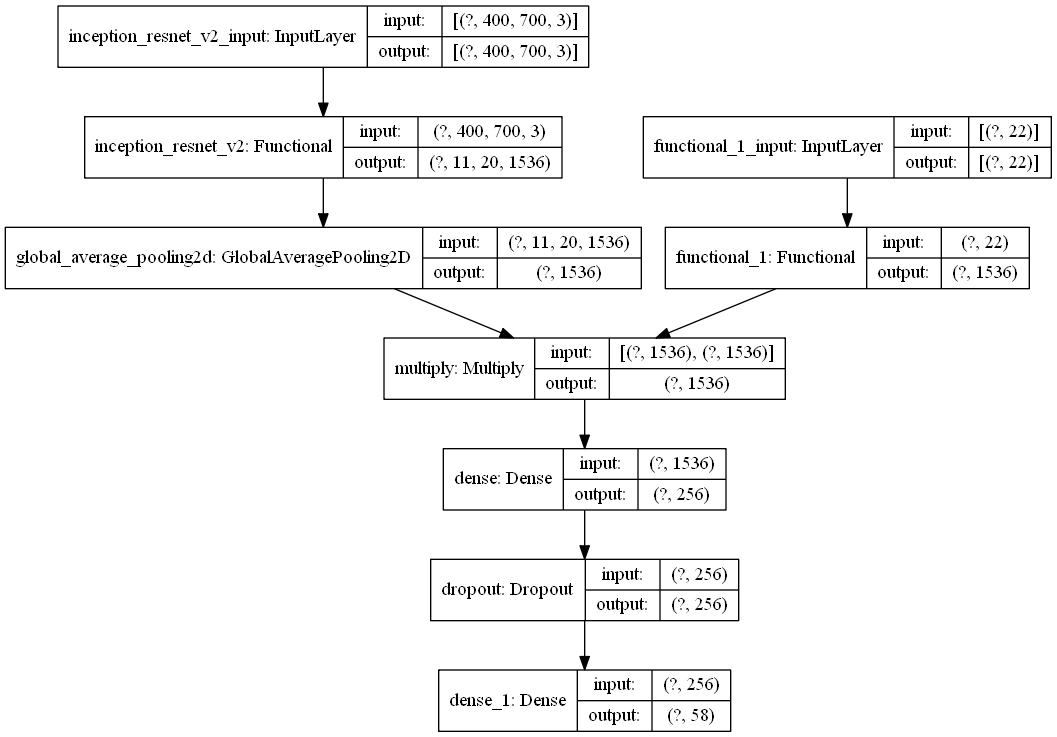

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [28]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.CategoricalCrossentropy() 


# learning rate
lr = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------


# Validation metrics
# ------------------
metrics = ['accuracy']
# ------------------



# Compile Model
model.compile(optimizer=optimizer, loss=loss , metrics=metrics)

In [29]:
import os
from datetime import datetime

cwd1 = os.getcwd()

exps_dir = os.path.join(cwd1, 'multiclass_exps')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True, save_best_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)/bs,#+len(dataset1)
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/bs, #+len(dataset_valid1)
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
5287/5286 [==============================] - 7144s 1s/step - loss: 1.4367 - accuracy: 0.4718 - val_loss: 1.1713 - val_accuracy: 0.5379
Epoch 2/100
5287/5286 [==============================] - 7143s 1s/step - loss: 1.0811 - accuracy: 0.5624 - val_loss: 1.0589 - val_accuracy: 0.5675
Epoch 3/100
5287/5286 [==============================] - 7271s 1s/step - loss: 0.9723 - accuracy: 0.6003 - val_loss: 1.0179 - val_accuracy: 0.5869
Epoch 4/100
5287/5286 [==============================] - 7361s 1s/step - loss: 0.8950 - accuracy: 0.6279 - val_loss: 0.9940 - val_accuracy: 0.5928
Epoch 5/100
5287/5286 [==============================] - 7425s 1s/step - loss: 0.8254 - accuracy: 0.6565 - val_loss: 1.0081 - val_accuracy: 0.5955
Epoch 6/100
5287/5286 [==============================] - 7108s 1s/step - loss: 0.7534 - accuracy: 0.6817 - val_loss: 1.0371 - val_accuracy: 0.5990
Epoch 7/100
5287/5286 [==============================] - 7067s 1s/step - loss: 0.6761 - accuracy: 0.7163 - val_loss: 1

In [30]:

from datetime import datetime

def create_csv(results, results_dir='../results'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [31]:
with open(test_QA) as f:
    test_dict = json.load(f)


MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

test_questions = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in test_dict:

#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    question = test_dict[key]['question']

    
    if (len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    test_questions.append(question)
    
    count += 1

test_tokenized = ita_tokenizer.texts_to_sequences(test_questions)

# Pad to max italian sentence length
test_encoder_inputs = pad_sequences(test_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", test_encoder_inputs.shape)

count = 0
for key in test_dict:
    test_dict[key]['question'] = test_encoder_inputs[count]
    count+=1

Italian encoder inputs shape: (6372, 22)


In [32]:
#Prediction computation done one image at time

#model.load_weights(filepath='C:\\Users\\ASUS\\Documents\\Università\\ANNDL\\A2NDLKaggle\\weights\\FC_Nov14_15-02-54\\ckpts\\cp.ckpt')

from PIL import Image
count = 0
results = {}
for key in test_dict:

    # Read Image
    element = test_dict[key]
    image = element['image_id']
    img = Image.open(os.path.join(cwd, 'Images', image + '.png'))
    #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    img = img.convert('RGB')
    
    # Resize image and mask
    img = img.resize((img_w,img_h))
    img_arr = preprocess_input(np.array(img))
    question = element['question']
    
    pair = {"vgg16_input": img_arr, "zzz_input": question}  
    
    pair['vgg16_input']=tf.expand_dims(pair['vgg16_input'],0)
    pair['zzz_input']=tf.expand_dims(pair['zzz_input'],0)
    
    predictions = np.argmax(model.predict(pair))
    results[key] = predictions
    print (str(count) + ":" +str(predictions))
    count += 1
create_csv(results)


0:49
1:15
2:2
3:33
4:1
5:0
6:2
7:33
8:57
9:57
10:33
11:28
12:5
13:33
14:33
15:33
16:28
17:57
18:33
19:1
20:57
21:45
22:38
23:2
24:5
25:3
26:57
27:40
28:57
29:33
30:2
31:22
32:57
33:2
34:33
35:57
36:2
37:56
38:57
39:2
40:57
41:56
42:2
43:33
44:38
45:57
46:57
47:33
48:33
49:33
50:2
51:57
52:7
53:57
54:33
55:2
56:5
57:1
58:57
59:33
60:53
61:17
62:41
63:57
64:2
65:39
66:2
67:57
68:54
69:57
70:33
71:33
72:57
73:2
74:26
75:33
76:33
77:56
78:14
79:46
80:33
81:3
82:17
83:57
84:2
85:1
86:32
87:39
88:11
89:17
90:33
91:28
92:30
93:53
94:57
95:33
96:2
97:33
98:11
99:18
100:57
101:57
102:37
103:33
104:57
105:33
106:33
107:2
108:57
109:5
110:2
111:57
112:56
113:6
114:33
115:33
116:43
117:11
118:20
119:28
120:57
121:33
122:1
123:57
124:33
125:57
126:21
127:0
128:2
129:57
130:57
131:2
132:2
133:56
134:26
135:2
136:2
137:2
138:33
139:33
140:2
141:57
142:33
143:34
144:57
145:57
146:2
147:2
148:40
149:33
150:57
151:2
152:2
153:24
154:38
155:57
156:5
157:57
158:9
159:2
160:57
161:2
162:39
163:27
164:48
16

1194:2
1195:20
1196:0
1197:21
1198:57
1199:39
1200:57
1201:2
1202:2
1203:16
1204:57
1205:57
1206:53
1207:33
1208:2
1209:57
1210:26
1211:33
1212:18
1213:41
1214:33
1215:2
1216:2
1217:57
1218:33
1219:2
1220:33
1221:57
1222:57
1223:2
1224:57
1225:33
1226:41
1227:33
1228:57
1229:57
1230:2
1231:11
1232:57
1233:33
1234:33
1235:39
1236:57
1237:2
1238:57
1239:57
1240:2
1241:2
1242:17
1243:33
1244:57
1245:33
1246:2
1247:41
1248:24
1249:57
1250:4
1251:2
1252:25
1253:57
1254:2
1255:57
1256:57
1257:41
1258:17
1259:3
1260:57
1261:4
1262:57
1263:57
1264:33
1265:55
1266:57
1267:33
1268:33
1269:57
1270:57
1271:33
1272:43
1273:57
1274:39
1275:57
1276:57
1277:9
1278:3
1279:21
1280:57
1281:37
1282:3
1283:16
1284:33
1285:3
1286:57
1287:33
1288:2
1289:0
1290:5
1291:21
1292:39
1293:2
1294:13
1295:18
1296:25
1297:33
1298:21
1299:10
1300:39
1301:33
1302:2
1303:2
1304:15
1305:39
1306:33
1307:43
1308:2
1309:44
1310:28
1311:56
1312:54
1313:57
1314:1
1315:33
1316:10
1317:52
1318:18
1319:2
1320:2
1321:33
1322:57
1

2249:57
2250:57
2251:33
2252:17
2253:57
2254:57
2255:33
2256:33
2257:33
2258:57
2259:39
2260:33
2261:13
2262:51
2263:29
2264:30
2265:33
2266:50
2267:39
2268:33
2269:33
2270:57
2271:33
2272:21
2273:33
2274:2
2275:3
2276:37
2277:33
2278:57
2279:57
2280:17
2281:37
2282:11
2283:10
2284:18
2285:57
2286:5
2287:39
2288:2
2289:16
2290:2
2291:1
2292:2
2293:20
2294:2
2295:2
2296:33
2297:57
2298:39
2299:33
2300:57
2301:13
2302:2
2303:57
2304:53
2305:57
2306:2
2307:3
2308:21
2309:3
2310:41
2311:57
2312:39
2313:4
2314:0
2315:57
2316:33
2317:53
2318:33
2319:57
2320:33
2321:13
2322:57
2323:33
2324:17
2325:57
2326:17
2327:2
2328:49
2329:33
2330:3
2331:2
2332:17
2333:57
2334:42
2335:2
2336:33
2337:33
2338:1
2339:24
2340:56
2341:41
2342:20
2343:33
2344:16
2345:57
2346:33
2347:13
2348:57
2349:57
2350:39
2351:57
2352:13
2353:3
2354:39
2355:57
2356:57
2357:2
2358:57
2359:33
2360:33
2361:3
2362:50
2363:4
2364:35
2365:33
2366:18
2367:2
2368:2
2369:57
2370:2
2371:38
2372:33
2373:57
2374:2
2375:57
2376:33
2377

3301:2
3302:57
3303:57
3304:33
3305:33
3306:0
3307:33
3308:57
3309:21
3310:57
3311:57
3312:33
3313:57
3314:57
3315:2
3316:2
3317:4
3318:20
3319:39
3320:43
3321:33
3322:2
3323:57
3324:33
3325:51
3326:57
3327:57
3328:0
3329:57
3330:24
3331:50
3332:56
3333:40
3334:33
3335:2
3336:33
3337:57
3338:57
3339:33
3340:2
3341:57
3342:57
3343:33
3344:4
3345:33
3346:32
3347:2
3348:57
3349:33
3350:41
3351:35
3352:1
3353:17
3354:57
3355:57
3356:5
3357:53
3358:1
3359:33
3360:57
3361:2
3362:55
3363:33
3364:57
3365:33
3366:22
3367:40
3368:57
3369:57
3370:57
3371:57
3372:2
3373:33
3374:33
3375:49
3376:33
3377:31
3378:57
3379:56
3380:57
3381:33
3382:57
3383:33
3384:39
3385:57
3386:2
3387:57
3388:57
3389:57
3390:57
3391:33
3392:57
3393:24
3394:33
3395:57
3396:2
3397:57
3398:33
3399:50
3400:57
3401:22
3402:24
3403:57
3404:11
3405:33
3406:44
3407:57
3408:56
3409:33
3410:57
3411:57
3412:57
3413:33
3414:17
3415:2
3416:57
3417:57
3418:57
3419:2
3420:57
3421:20
3422:2
3423:57
3424:2
3425:57
3426:3
3427:17
3428:57

4356:32
4357:57
4358:2
4359:1
4360:33
4361:33
4362:13
4363:14
4364:4
4365:57
4366:56
4367:5
4368:33
4369:33
4370:33
4371:33
4372:57
4373:33
4374:57
4375:39
4376:33
4377:39
4378:1
4379:33
4380:2
4381:57
4382:2
4383:2
4384:37
4385:57
4386:22
4387:5
4388:57
4389:57
4390:13
4391:57
4392:39
4393:33
4394:57
4395:57
4396:57
4397:33
4398:21
4399:2
4400:57
4401:39
4402:57
4403:2
4404:57
4405:39
4406:57
4407:22
4408:57
4409:57
4410:15
4411:2
4412:57
4413:33
4414:2
4415:2
4416:57
4417:57
4418:33
4419:51
4420:57
4421:57
4422:57
4423:33
4424:57
4425:21
4426:57
4427:33
4428:33
4429:57
4430:33
4431:34
4432:2
4433:20
4434:33
4435:39
4436:21
4437:56
4438:2
4439:57
4440:1
4441:18
4442:33
4443:2
4444:33
4445:2
4446:43
4447:37
4448:33
4449:57
4450:15
4451:57
4452:57
4453:57
4454:33
4455:57
4456:22
4457:57
4458:11
4459:20
4460:5
4461:2
4462:54
4463:27
4464:2
4465:48
4466:21
4467:1
4468:57
4469:46
4470:56
4471:57
4472:54
4473:57
4474:30
4475:40
4476:33
4477:11
4478:57
4479:57
4480:2
4481:33
4482:56
4483:57


5407:57
5408:2
5409:9
5410:57
5411:57
5412:20
5413:57
5414:33
5415:38
5416:2
5417:57
5418:33
5419:57
5420:33
5421:57
5422:53
5423:57
5424:57
5425:33
5426:33
5427:57
5428:57
5429:3
5430:17
5431:57
5432:57
5433:31
5434:57
5435:39
5436:56
5437:2
5438:57
5439:57
5440:2
5441:41
5442:22
5443:57
5444:57
5445:56
5446:33
5447:39
5448:2
5449:33
5450:57
5451:57
5452:2
5453:57
5454:57
5455:57
5456:2
5457:33
5458:56
5459:39
5460:12
5461:18
5462:56
5463:57
5464:33
5465:15
5466:37
5467:41
5468:33
5469:36
5470:33
5471:57
5472:4
5473:22
5474:2
5475:2
5476:38
5477:50
5478:53
5479:15
5480:46
5481:21
5482:33
5483:57
5484:17
5485:4
5486:2
5487:33
5488:33
5489:2
5490:57
5491:33
5492:35
5493:39
5494:57
5495:30
5496:2
5497:33
5498:33
5499:57
5500:33
5501:16
5502:57
5503:2
5504:33
5505:1
5506:26
5507:57
5508:39
5509:57
5510:33
5511:33
5512:2
5513:28
5514:57
5515:40
5516:57
5517:57
5518:22
5519:33
5520:57
5521:10
5522:46
5523:33
5524:57
5525:3
5526:17
5527:57
5528:2
5529:57
5530:46
5531:2
5532:57
5533:21
5534:4

In [32]:
train_dataset.element_spec

({'vgg16_input': TensorSpec(shape=(None, 400, 700, 3), dtype=tf.float32, name=None),
  'model_input': TensorSpec(shape=(None, 22), dtype=tf.float32, name=None)},
 TensorSpec(shape=(None, 58), dtype=tf.float32, name=None))

In [ ]:
model.inputs

In [58]:
model.save_weights(os.path.join(os.getcwd(),'multiclass_exps/Manual/ckpts/cp.ckpt'))


In [32]:
train_dataset

<RepeatDataset shapes: ({input_1: (None, 400, 700, 3), input_2: (None, 22)}, (None, 58)), types: ({input_1: tf.float32, input_2: tf.float32}, tf.float32)>

AttributeError: 'dict' object has no attribute 'shape'